# Office Items Multi-class classification

This notebook generalizes the cats and dogs example to a more complicated classification task with more classes.

# Step 1: Pre-train the model on 150K images from PASS using SimCLR style training

## Import the necessary modules and define some helper functions

In [2]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## Define Training Configurations (args)

In [3]:
class Config:
    def __init__(self):
        self.dataset_name = "pass"
        self.dataset_fn = pass_get_datasets
        self.num_classes = 0
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 512
        self.validation_split = 0.0
        self.log_prefix = "SSL"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/PASS_dataset/"
        self.deterministic = True
        self.print_freq = 50
        self.labels = None
        self.lr = 0.001
        self.num_epochs = 100
        self.qat_policy = {'start_epoch':15, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()
conf.is_classification = False

## Set up the logger

In [4]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/SSL___2022.07.08-153522/SSL___2022.07.08-153522.log
dataset_name:pass
dataset_fn=<function pass_get_datasets at 0x7fa4fa6749d0>
num_classes=0
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=512
validation_split=0.0
lr=0.001000
num_epochs=100
qat_policy={'start_epoch': 15, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and visualize the dataset
* Each sample is a pair of augmented images

../Datasets/PASS_dataset/train


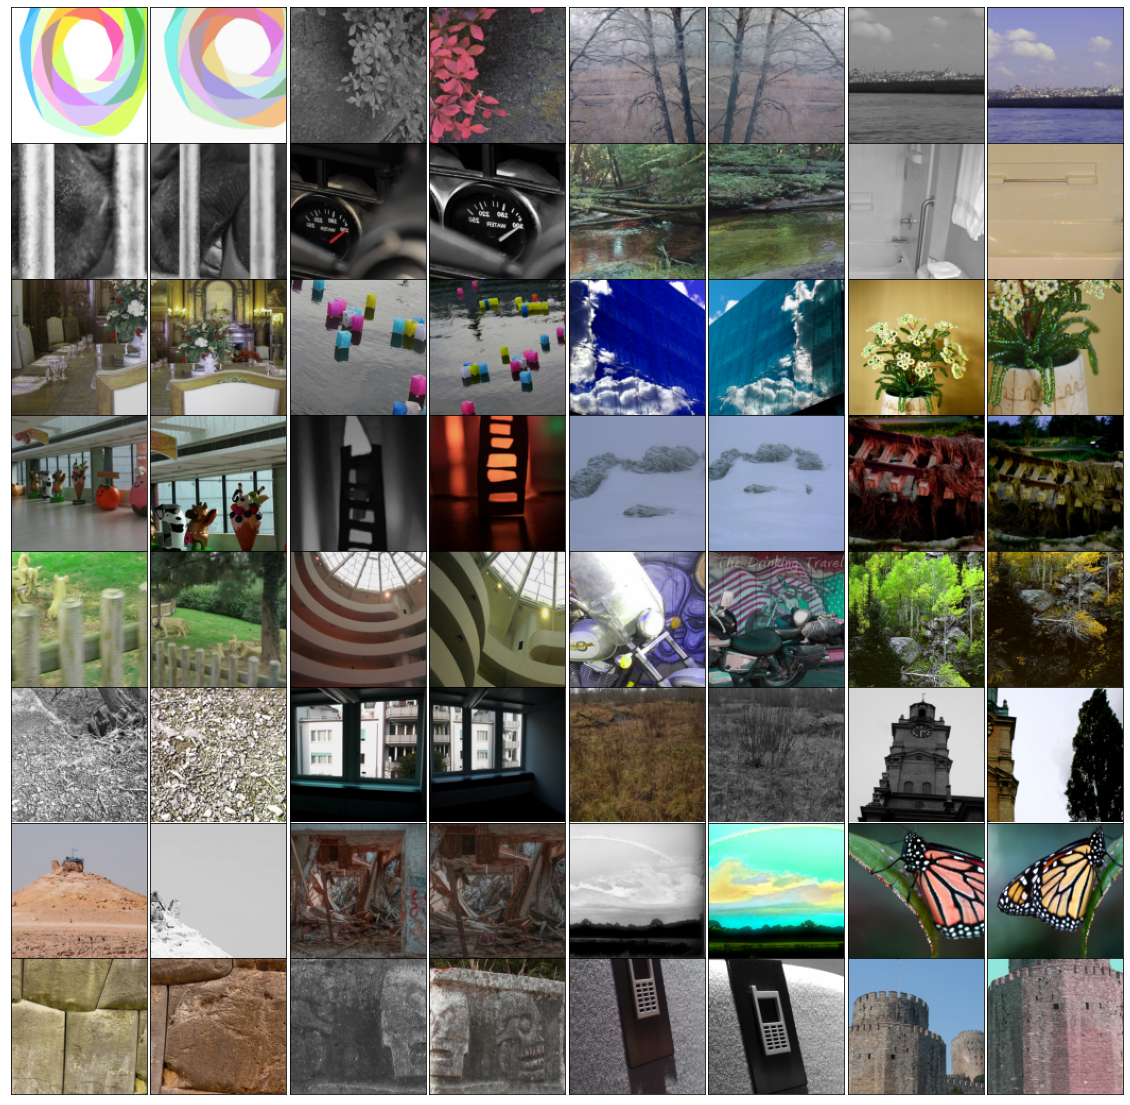

In [5]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

## Create the data loaders

In [6]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=149999
	validation=1
	test=1
Augmentations:Compose(
    RandomResizedCrop(size=(128, 128), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.1, 0.1))
    RandomGrayscale(p=0.25)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/PASS_dataset/train
../Datasets/PASS_dataset/test


## Set up the device, cuda or cpu

In [7]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model for training

In [ ]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.ClassifierBackbone()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

## Set up optimizer, loss, and learning schedule

In [9]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device,temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(device)
        self.temperature = self.temperature.to(device)
        self.device = device
            
    def forward(self, emb_i, emb_j):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        batch_size = self.batch_size
        self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
        self.negatives_mask = self.negatives_mask.to(self.device)
        if emb_i.size()[0] != self.batch_size:
            batch_size = emb_i.size()[0]
            self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            self.negatives_mask = self.negatives_mask.to(self.device)

        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
    
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * batch_size)
        # print("CL: ",loss)
        return loss

In [10]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[15, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = ContrastiveLoss(conf.batch_size,conf.device,0.5).to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({15: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function
* this generalizes the way we do a forward pass so we can reuse the training/validation functions for different models

In [11]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    input1, input2 = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(input1), model(input2)

conf.forward = classifier_forward

## Validation Function

In [4]:
def validate(data_loader, model, loggers, conf, epoch=-1, tflogger=None):
    """Execute the validation/test loop."""

    # store loss stats
    losses = {'objective_loss': tnt.AverageValueMeter()}
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

    # validation set info
    total_samples = len(data_loader.sampler)
    confusion = tnt.ConfusionMeter(conf.num_classes)
    total_steps = (total_samples + conf.batch_size - 1) // conf.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf.batch_size)

    # Switch to evaluation mode
    model.eval()

    class_probs = []
    class_preds = []

    try:
        # iterate over the batches in the validation set
        for validation_step, batch in enumerate(data_loader):
            with torch.no_grad():

                output, target = conf.forward(model, batch, conf)

                # compute loss
                loss = conf.criterion(output, target)

                # measure accuracy and record loss
                losses['objective_loss'].add(loss.item())
                classerr.add(output.data, target)
                confusion.add(output.data, target)

                # store prediction stats
                steps_completed = (validation_step+1)
                if steps_completed % conf.print_freq == 0 or steps_completed == total_steps:
                    class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in output]
                    _, class_preds_batch = torch.max(output, 1)
                    class_probs.append(class_probs_batch)
                    class_preds.append(class_preds_batch)

                    stats = (
                        '',
                        OrderedDict([('Loss', losses['objective_loss'].mean),
                                    ('Top1', classerr.value(1))])
                    )
                    if conf.num_classes > 5:
                        stats[1]['Top5'] = classerr.value(5)

                    distiller.log_training_progress(stats, None, epoch, steps_completed, total_steps, conf.print_freq, loggers)
    except IndexError:
        print("Index error")
        print("dataset length:",len(data_loader.dataset))
        steps = [validation_step for validation_step, batch in enumerate(data_loader)]
        print("final validation step:", steps[-1])

    if conf.num_classes > 5:
        msglogger.info('==> Top1: %.3f    Top5: %.3f    Loss: %.3f\n', classerr.value()[0], classerr.value()[1], losses['objective_loss'].mean)
    else:
        try:
            msglogger.info('==> Top1: %.3f    Loss: %.3f\n', classerr.value()[0], losses['objective_loss'].mean)
        except ZeroDivisionError:
            print("Zero division error")
            print(classerr.value())
            print(losses['objective_loss'])

    msglogger.info('==> Confusion:\n%s\n', str(confusion.value()))
    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion.value(), conf.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix', cf, epoch,
                                            dataformats='HWC')
   
    return classerr.value(1), classerr.value(min(conf.num_classes, 5)), losses['objective_loss'].mean

## Training Function

In [5]:
def train(train_loader, val_loader, test_loader, model, conf):

    # store model history across epochs
    perf_scores_history = []
    model = model.to(conf.device)

    # start the clock
    tic = datetime.now()

    # =============================== training loop =====================================
    for epoch in range(conf.start_epoch, conf.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(model, conf.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            model.to(conf.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf.model_name = f'{conf.model_name}_qat'

        # store loss and training stats
        losses = {'objective_loss': tnt.AverageValueMeter()}
        classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf.num_classes, 5)))

        # logging stats
        total_samples = len(train_loader.sampler)
        steps_per_epoch = (total_samples + conf.batch_size - 1) // conf.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf.batch_size)

        # Switch to train mode
        model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        for train_step, batch in enumerate(train_loader):
            output, target = conf.forward(model,batch,conf)
       
            loss = conf.criterion(output, target)

            # on the last batch store the stats for the epoch
            if conf.is_classification:
                if train_step >= len(train_loader)-2:
                    classerr.add(output.data, target)
                    acc_stats.append([classerr.value(1), classerr.value(min(conf.num_classes, 5))])

            # add the loss for each batch
            losses["objective_loss"].add(loss.item())

            # reset the optimizer
            conf.optimizer.zero_grad()

            # backwards pass and parameter update
            loss.backward()
            conf.optimizer.step()

            # track batch stats
            steps_completed = (train_step+1)

            # log stats every 10 batches
            if steps_completed % conf.print_freq == 0 or steps_completed == steps_per_epoch:
                if conf.is_classification:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr.n != 0:
                        errs['Top1'] = classerr.value(1)
                        if conf.num_classes > 5:
                            errs['Top5'] = classerr.value(5)
                    else:
                        errs['Top1'] = None
                        errs['Top5'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)
                else:
                    stats_dict = OrderedDict()
                    for loss_name, meter in losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict['LR'] = conf.optimizer.param_groups[0]['lr']
                    stats = ('Performance/Training/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf.print_freq,all_loggers)


        # ============================= validation =======================
        if conf.is_classification:
            msglogger.info('--- validate (epoch=%d)-----------', epoch)
            top1, top5, vloss = validate(val_loader, model, [pylogger], conf, epoch, tflogger)

            # store validation stats
            stats = ('Performance/Validation/', OrderedDict([('Loss', vloss), ('Top1', top1)]))
            if conf.num_classes > 5:
                stats[1]['Top5'] = top5

            distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                    log_freq=1, loggers=all_tbloggers)

            perf_scores_history.append(distiller.MutableNamedTuple({'top1': top1, 'top5': top5,
                                                                    'epoch': epoch}))
            # Keep perf_scores_history sorted from best to worst
            # Sort by top1 as main sort key, then sort by top5 and epoch
            perf_scores_history.sort(key=operator.attrgetter('top1', 'top5', 'epoch'),reverse=True)
            for score in perf_scores_history[:1]:
                if conf.num_classes > 5:
                    msglogger.info('==> Best [Top1: %.3f   Top5: %.3f  on epoch: %d]',
                                    score.top1, score.top5,score.epoch)
                else:
                    msglogger.info('==> Best [Top1: %.3f on epoch: %d]',
                                    score.top1, score.epoch)

            # Save the checkpoint
            is_best = epoch == perf_scores_history[0].epoch
            checkpoint_extras = {'current_top1': top1,
                                'best_top1': perf_scores_history[0].top1,
                                'best_epoch': perf_scores_history[0].epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=is_best, name=conf.model_name,
                                        dir=msglogger.logdir)
        else:
            checkpoint_extras = {'epoch': epoch}

            apputils.save_checkpoint(epoch, conf.model_name, model, optimizer=conf.optimizer,
                                        scheduler=compression_scheduler, extras=checkpoint_extras,
                                        is_best=False, name=conf.model_name,
                                        dir=msglogger.logdir)
        conf.lr_scheduler.step()

    # ========================= test ============================
    if conf.is_classification:
        top1, top5, losses = validate(test_loader, model, [pylogger], conf, epoch, tflogger)
        msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

## Train the model

In [15]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 149999 samples (512 per mini-batch)
Epoch: [0][   50/  293]    objective_loss 6.327590    LR 0.001000    
Epoch: [0][  100/  293]    objective_loss 6.188396    LR 0.001000    
Epoch: [0][  150/  293]    objective_loss 6.112148    LR 0.001000    
Epoch: [0][  200/  293]    objective_loss 6.060225    LR 0.001000    
Epoch: [0][  250/  293]    objective_loss 6.021627    LR 0.001000    
Epoch: [0][  293/  293]    objective_loss 5.994458    LR 0.001000    
Saving checkpoint to: jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 149999 samples (512 per mini-batch)
Epoch: [1][   50/  293]    objective_loss 5.820022    LR 0.001000    
Epoch: [1][  100/  293]    objective_loss 5.810583    LR 0.001000    
Epoch: [1][  150/  293]    objective_loss 5.801435    LR 0.001000    
Epoch: [1][  200/  293]    objective_loss 5.793186    LR 0.001000    
Epoch: [1][  250/  293]    objective_loss 5.785349    LR 0.001000    
Epoch: [1][  293/  293]

QAT is starting!


Epoch: [15][   50/  293]    objective_loss 6.000985    LR 0.000500    
Epoch: [15][  100/  293]    objective_loss 5.877875    LR 0.000500    
Epoch: [15][  150/  293]    objective_loss 5.823676    LR 0.000500    
Epoch: [15][  200/  293]    objective_loss 5.790519    LR 0.000500    
Epoch: [15][  250/  293]    objective_loss 5.766028    LR 0.000500    
Epoch: [15][  293/  293]    objective_loss 5.752880    LR 0.000500    
Saving checkpoint to: jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
Training epoch: 149999 samples (512 per mini-batch)
Epoch: [16][   50/  293]    objective_loss 5.669785    LR 0.000500    
Epoch: [16][  100/  293]    objective_loss 5.666034    LR 0.000500    
Epoch: [16][  150/  293]    objective_loss 5.663752    LR 0.000500    
Epoch: [16][  200/  293]    objective_loss 5.660262    LR 0.000500    
Epoch: [16][  250/  293]    objective_loss 5.657775    LR 0.000500    
Epoch: [16][  293/  293]    objective_loss 5.656271    LR 0.

# Step 2: Fine-tune pre-trained encoder to office5 dataset

## Import modules if starting from here

In [28]:
%load_ext autoreload
%autoreload 2

In [29]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## Define new training parameters for classification

In [31]:
class Config:
    def __init__(self):
        self.dataset_name = "office5"
        self.dataset_fn = office5_get_datasets
        self.num_classes = 5
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.12
        self.log_prefix = "finetune_office5_run3"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/office5/source/"
        self.deterministic = False
        self.print_freq = 50
        self.labels = ('back_pack', 'keyboard','laptop','mouse','pen')
        self.lr = 0.001
        self.num_epochs = 64
        self.qat_policy = {'start_epoch':8, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

## Set up the logger

In [ ]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

## Visualize a batch of 64 images
* each sample is an item from the source dataset, the lables are above each image

../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


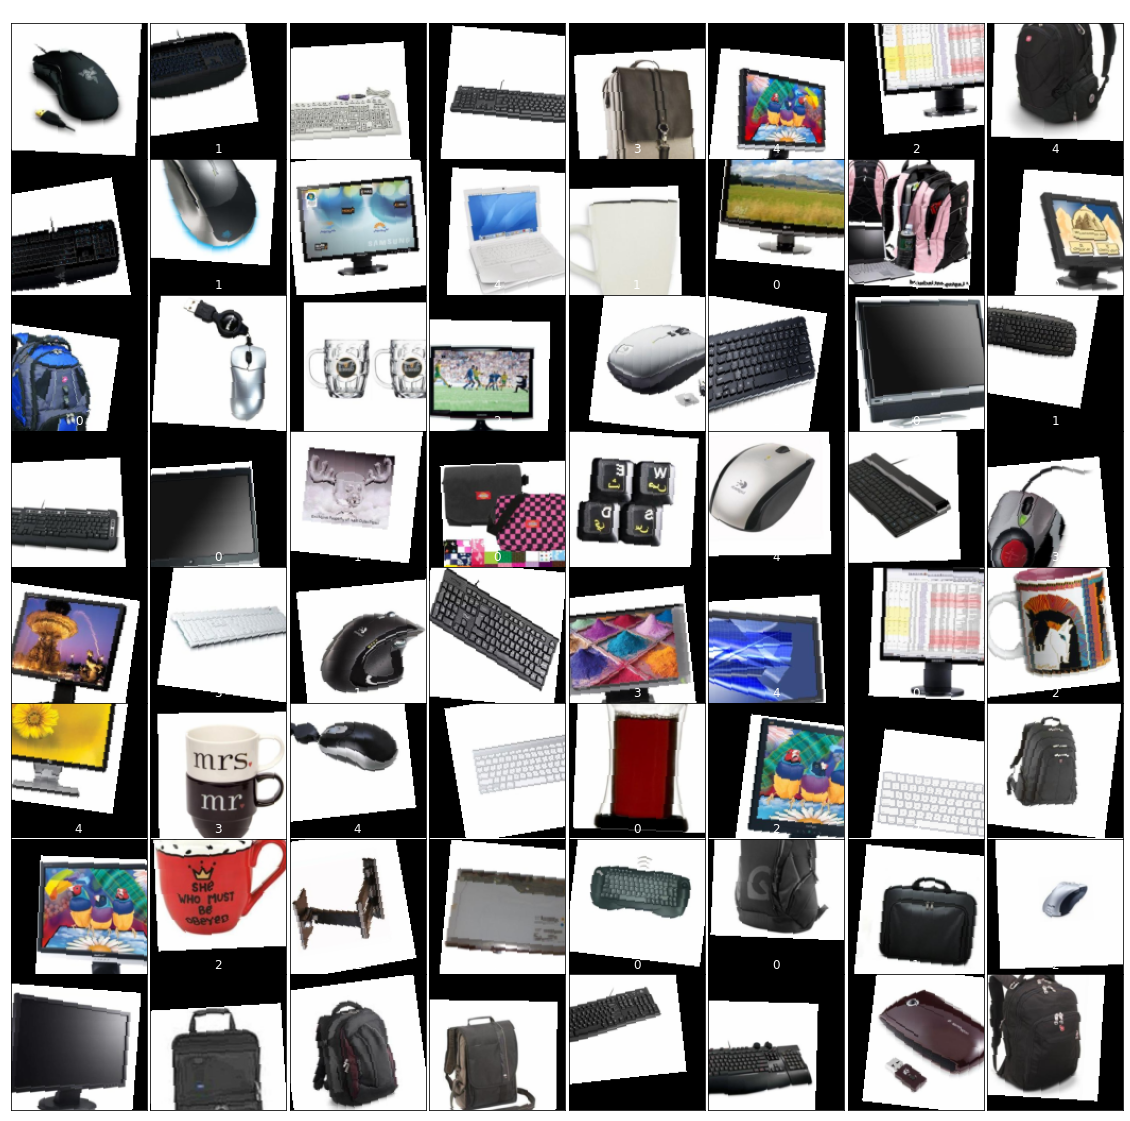

In [33]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

## Create the dataloaders

In [19]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=385
	validation=52
	test=48
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.27, 0.27))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


## Set up the device

In [20]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model

In [21]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


## Set up the optimizer and loss

In [22]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[8, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({8: 1, 20: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [23]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

## Train the model

In [24]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 385 samples (32 per mini-batch)
Epoch: [0][   13/   13]    objective_loss 1.463681    Top1 45.454545    LR 0.001000    
--- validate (epoch=0)-----------
52 samples (32 per mini-batch)
Epoch: [0][    2/    2]    Loss 1.344790    Top1 51.923077    
==> Top1: 51.923    Loss: 1.345

==> Confusion:
[[9 2 1 0 1]
 [0 6 3 0 0]
 [0 0 8 0 0]
 [0 4 4 0 2]
 [2 0 6 0 4]]

==> Best [Top1: 51.923 on epoch: 0]
Saving checkpoint to: jupyter_logging/finetune_office5_min_aug___2022.07.14-094447/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 385 samples (32 per mini-batch)
Epoch: [1][   13/   13]    objective_loss 1.248713    Top1 45.454545    LR 0.001000    
--- validate (epoch=1)-----------
52 samples (32 per mini-batch)
Epoch: [1][    2/    2]    Loss 1.191777    Top1 46.153846    
==> Top1: 46.154    Loss: 1.192

==> Confusion:
[[5 1 1 2 4]
 [0 5 4 0 0]
 [0 0 8 0 0]
 [1 2 4 0 3]
 [1 0 5 0 6]]

==> Best [Top1: 51.923 on epoch: 0]
Saving checkpoint to: jupyter_logging/finetune

QAT is starting!


Epoch: [8][   13/   13]    objective_loss 0.460985    Top1 87.878788    LR 0.000500    
--- validate (epoch=8)-----------
52 samples (32 per mini-batch)
Epoch: [8][    2/    2]    Loss 0.711897    Top1 78.846154    
==> Top1: 78.846    Loss: 0.712

==> Confusion:
[[12  0  0  1  0]
 [ 0  5  1  3  0]
 [ 0  0  5  1  2]
 [ 0  0  0  8  2]
 [ 1  0  0  0 11]]

==> Best [Top1: 78.846 on epoch: 8]
Saving checkpoint to: jupyter_logging/finetune_office5_min_aug___2022.07.14-094447/classifierbackbonenet_qat_checkpoint.pth.tar
Training epoch: 385 samples (32 per mini-batch)
Epoch: [9][   13/   13]    objective_loss 0.543215    Top1 81.818182    LR 0.000500    
--- validate (epoch=9)-----------
52 samples (32 per mini-batch)
Epoch: [9][    2/    2]    Loss 0.703370    Top1 73.076923    
==> Top1: 73.077    Loss: 0.703

==> Confusion:
[[11  0  0  2  0]
 [ 0  6  1  2  0]
 [ 0  0  7  1  0]
 [ 1  0  2  7  0]
 [ 1  0  3  1  7]]

==> Best [Top1: 78.846 on epoch: 8]
Saving checkpoint to: jupyter_logging/fi

## Visualize Embeddings

In [25]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False):
    _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
    preds = model(batch_imgs)
    embds = activation['fc1']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

### 1: Visualize office clusters from dataset and from camera  
* for the dataset images, set the test_batch_path to ../Datasets/office5/source/
* for the camera images, set the test_batch_path to ../Datasets/office5/target/  

We see that for this particular batch of images we get **65.00%** on the **camera** batch and **91.83%** on the **dataset** batch. When visualizing the output embeddings of the CNN encoder we also see that the dataset batch clusters better

In [27]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5_test_baseline/",conf,256,"jupyter_logging/finetune_office5_min_aug___2022.07.14-094447/classifierbackbonenet_qat_best.pth.tar",model,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/office5_test_baseline/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.
batch acc:  0.4807692307692308


### 2: Visualize difference in domains
* path is ../Datasets/office5_both  

From the embeddings we can see that there is a shift between the domains, e.g. all the keyboard images should cluster together rather than form independent clusters based on the domain

In [19]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5_both/",conf,256,"jupyter_logging/finetune_office5___2022.07.13-142419/classifierbackbonenet_qat_best.pth.tar",model,False)

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/office5_both/test
{'back_pack_camera': 0, 'mouse_dataset': 1, 'keyboard_dataset': 2, 'monitor_dataset': 3, 'mug_dataset': 4, 'back_pack_dataset': 5, 'keyboard_camera': 6, 'monitor_camera': 7, 'mug_camera': 8, 'mouse_camera': 9}
Configuring device: MAX78000, simulate=False.


# Step 3: Quantization and Synthesis
* this code block is not repeated later so reuse it for synthesizing the model after domain-adaptation

## Quantize the model

You must change the kernel to execute within the ai8x-synthesis virtual environment

In [2]:
%load_ext autoreload
%autoreload 2
%run ../ai8x-synthesis/quantize.py jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best.pth.tar jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best-q.pth.tar --device MAX78000 -v

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Configuring device: MAX78000
Converting checkpoint file jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best.pth.tar to jupyter_logging/dcd_train_adv_k8run2___2022.07.14-150419/officeclassifier_qat_best-q.pth.tar

Model keys (state_dict):
feature_extractor.conv1.output_shift, feature_extractor.conv1.weight_bits, feature_extractor.conv1.bias_bits, feature_extractor.conv1.quantize_activation, feature_extractor.conv1.adjust_output_shift, feature_extractor.conv1.shift_quantile, feature_extractor.conv1.op.weight, feature_extractor.conv2.output_shift, feature_extractor.conv2.weight_bits, feature_extractor.conv2.bias_bits, feature_extractor.conv2.quantize_activation, feature_extractor.conv2.adjust_output_shift, feature_extractor.conv2.shift_quantile, feature_extractor.conv2.op.weight, feature_extractor.conv3.output_shift, feature_extractor.conv3.weight_bits, feature_extractor.

## Evaluate Quantized Model

Change virtual environment back to ai8x-training

## Import the needed modules

In [1]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

from classification import *

mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

## set up the model, choose desired checkpoint and corresponding architecture

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#load_model_path = 'jupyter_logging/dcd_train_adv___2022.07.08-100329/officeclassifier_qat_best.pth.tar-q.pth.tar'
#load_model_path = "jupyter_logging/finetune_office5___2022.07.07-161909/classifierbackbonenet_qat_best-q.pth.tar"
#load_model_path = "jupyter_logging/dcd_train_adv___2022.07.13-143739/officeclassifier_qat_best-q.pth.tar"
load_model_path = "jupyter_logging/dcd_train_adv_k8run3___2022.07.14-151603/officeclassifier_qat_best-q.pth.tar"

# Change this path to match file system layout
data_path = "../Datasets/office5_test_baseline/"

ai8x.set_device(device=85, simulate=True, round_avg=False)

model = mod.OfficeClassifier()
                          
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(model)
model = apputils.load_lean_checkpoint(model, load_model_path, model_device=device)
ai8x.update_model(model)
model = model.to(device)

Configuring device: MAX78000, simulate=True.


## Load the test data

In [10]:
args = Args(act_mode_8bit=True)

_, test_set = office5_get_datasets((data_path, args), load_train=False, load_test=True)
test_dataloader = DataLoader(test_set, batch_size=128, shuffle=False)

../Datasets/office5_test_baseline/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


## Simple test loop

In [14]:
model.eval()
acc = 0.
acc_weight = 0
with torch.no_grad():
    for image, label in test_dataloader:
        image = image.to(device)
        label = label.type(torch.long).to(device)
        model_out = model(image)
        label_out = torch.argmax(model_out, dim=1)

        tp = torch.sum(label_out == label)
        acc_batch = (tp / label_out.numel()).detach().item()
        acc += label_out.shape[0] * acc_batch
        acc_weight += label_out.shape[0]

    total_acc = 100 * (acc / acc_weight)
print(f'Quantized accuracy: {total_acc:.2f}%')

Quantized accuracy: 80.13%


## Create a sample image
* takes the first image from the test_loader
* change the name to be the model name

In [7]:
for image, label in test_dataloader:
    break
im_sample = (image[0].detach().cpu().numpy()).astype(np.int64)
np.save('../ai8x-synthesis/tests/sample_office.npy', im_sample)

## Visualize the test image
* we can see if the model simulation classifies it correctly at the bottom of the log.txt

tensor(0)

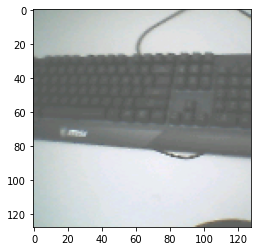

In [19]:
plt.imshow((image[0].detach().cpu().permute(1, 2, 0)+128)/255)
label[0]

## Model Synthesis
* make sure to specify the correct model path and configuration file

In [1]:
%cd ../ai8x-synthesis/
%run ai8xize.py --verbose --log --test-dir sdk/Examples/MAX78000/CNN --prefix office_DA_k8 --checkpoint-file ../ai8x-training/jupyter_logging/dcd_train_adv_k8run3___2022.07.14-151603/officeclassifier_qat_best-q.pth.tar --config-file networks/classifier.yaml --device MAX78000 --softmax --compact-data --mexpress --timer 0 --fifo --display-checkpoint

/home/geffencooper/Model_Development/ai8x-synthesis


WARNING:

Configuring device: MAX78000
Reading networks/classifier.yaml to configure network...
Reading ../ai8x-training/jupyter_logging/dcd_train_adv_k8run3___2022.07.14-151603/officeclassifier_qat_best-q.pth.tar to configure network weights...
Checkpoint for epoch 3, model officeclassifier_qat - weight and bias data:
 InCh OutCh  Weights         Quant Shift  Min  Max    Size Key                                       Bias       Quant  Min  Max Size Key
    3     8  (24, 3, 3)          8     0  -69   54     216 feature_extractor.conv1.op.weight         N/A            0    0    0    0 N/A                      
    8     8  (64, 3, 3)          8     0  -82   60     576 feature_extractor.conv2.op.weight         N/A            0    0    0    0 N/A                      
    8    16  (128, 3, 3)         8     0  -89   57    1152 feature_extractor.conv3.op.weight         N/A            0    0    0    0 N/A                      
   16    16  (256, 3, 3)         8     0  -71   66    2304 feature_extracto

Cannot check for updates for git branch "DA" from GitHub - Branch not found


WARNING:

Layer 11: `flatten` is not needed since input dimensions are 1x1.


WARNING:

Layer 12: `flatten` is not needed since input dimensions are 1x1.


Output()

office_DA_k8...


Output()

Output()

# Step 4: Now we do domain adaptation to improve the results  

## Let's first try a naive mix of the source and target training data

## Import the needed modules

In [50]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(conf, act_mode_8bit):
        conf.act_mode_8bit = act_mode_8bit
        conf.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [51]:
class Config:
    def __init__(self):
        self.dataset_name = "office5"
        self.dataset_fn = office5_get_datasets
        self.num_classes = 5
        self.model_name = "classifierbackbonenet"
        self.dimensions = (3,128,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.12
        self.log_prefix = "finetune_office5_naive_mix_run3"
        self.log_dir = "jupyter_logging"
        self.data_path = "../Datasets/office5/naive_mix/"
        self.deterministic = False
        self.print_freq = 50
        self.labels = ('back_pack', 'keyboard','laptop','mouse','pen')
        self.lr = 0.001
        self.num_epochs = 64
        self.qat_policy = {'start_epoch':8, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

In [52]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/finetune_office5_naive_mix_run3___2022.07.14-100554/finetune_office5_naive_mix_run3___2022.07.14-100554.log
dataset_name:office5
dataset_fn=<function office5_get_datasets at 0x7f820819a550>
num_classes=5
model_name=classifierbackbonenet
dimensions=(3, 128, 128)
batch_size=32
validation_split=0.12
lr=0.001000
num_epochs=64
qat_policy={'start_epoch': 8, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



../Datasets/office5/naive_mix/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


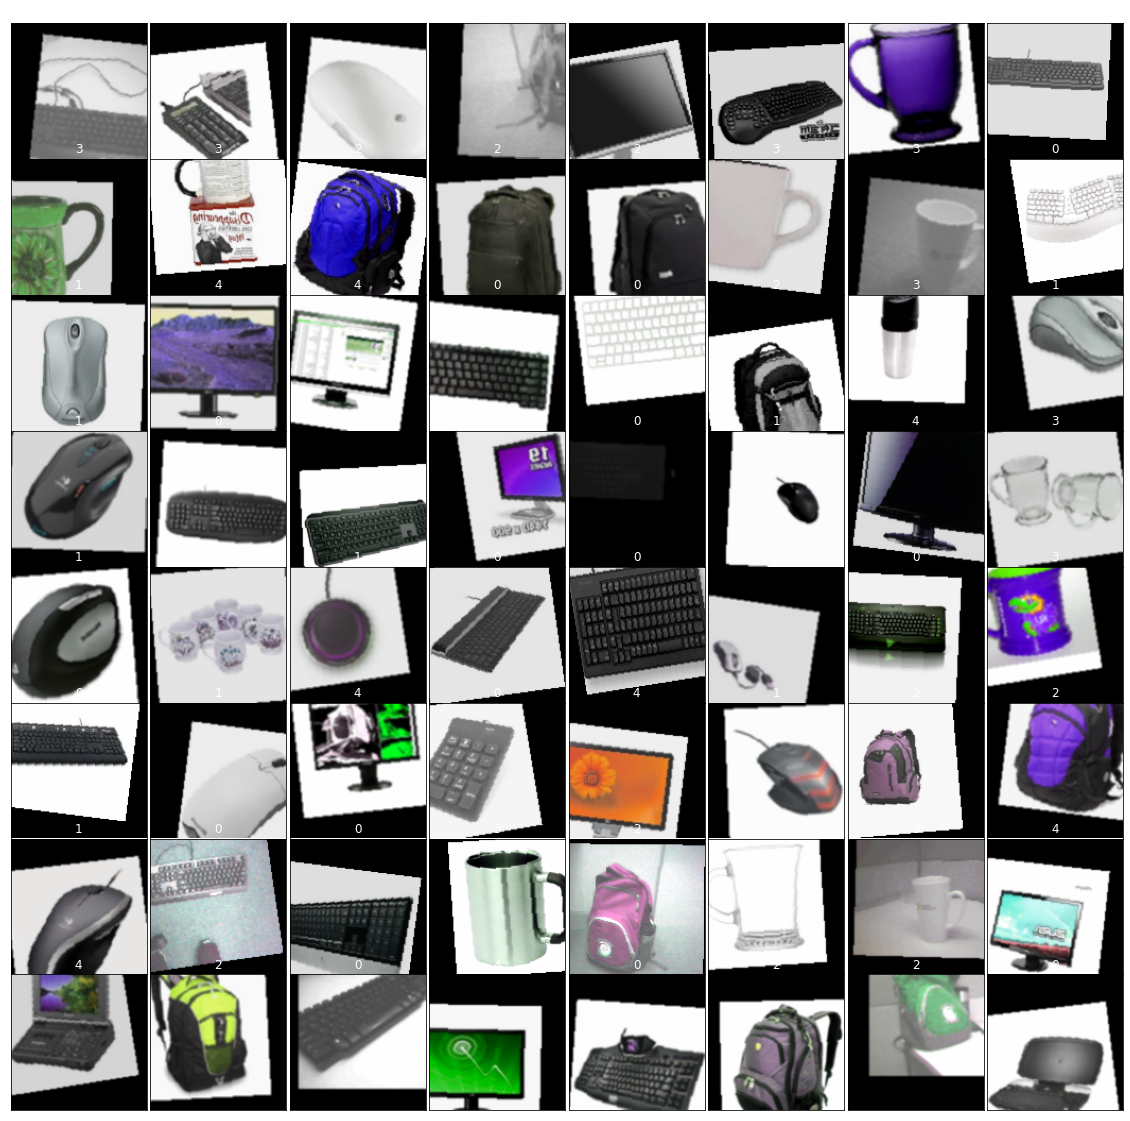

In [53]:
train_set, test_set = conf.dataset_fn((conf.data_path, args), load_train=True, load_test=False)
train_set.visualize_batch()

In [54]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, (conf.data_path,args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

Dataset sizes:
	training=420
	validation=57
	test=88
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    ColorJitter(brightness=(0.85, 1.15), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.4, 0.4))
    RandomGrayscale(p=0.15)
    RandomAffine(degrees=[-10.0, 10.0], translate=(0.27, 0.27))
    RandomHorizontalFlip(p=0.5)
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.5))
    ToTensor()
)


../Datasets/office5/naive_mix/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/naive_mix/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}


In [55]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


In [57]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeClassifier()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input, ), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


In [58]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[8, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({8: 1, 20: 1, 100: 1}) gamma: 0.5


In [59]:
def classifier_forward(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf.forward = classifier_forward

In [60]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 420 samples (32 per mini-batch)
Epoch: [0][   14/   14]    objective_loss 1.549485    Top1 22.222222    LR 0.001000    
--- validate (epoch=0)-----------
57 samples (32 per mini-batch)
Epoch: [0][    2/    2]    Loss 1.359979    Top1 40.350877    
==> Top1: 40.351    Loss: 1.360

==> Confusion:
[[ 4  1  6  0  1]
 [ 0  7  2  0  0]
 [ 0  0 12  0  0]
 [ 1  5  6  0  0]
 [ 0  0 12  0  0]]

==> Best [Top1: 40.351 on epoch: 0]
Saving checkpoint to: jupyter_logging/finetune_office5_naive_mix_run3___2022.07.14-100554/classifierbackbonenet_checkpoint.pth.tar
Training epoch: 420 samples (32 per mini-batch)
Epoch: [1][   14/   14]    objective_loss 1.216664    Top1 61.111111    LR 0.001000    
--- validate (epoch=1)-----------
57 samples (32 per mini-batch)
Epoch: [1][    2/    2]    Loss 1.127014    Top1 56.140351    
==> Top1: 56.140    Loss: 1.127

==> Confusion:
[[ 5  0  0  1  6]
 [ 0  8  1  0  0]
 [ 0  0  7  0  5]
 [ 0  1  2  2  7]
 [ 0  0  2  0 10]]

==> Best [Top1: 56.140 on

QAT is starting!


Epoch: [8][   14/   14]    objective_loss 0.618057    Top1 91.666667    LR 0.000500    
--- validate (epoch=8)-----------
57 samples (32 per mini-batch)
Epoch: [8][    2/    2]    Loss 0.519052    Top1 82.456140    
==> Top1: 82.456    Loss: 0.519

==> Confusion:
[[11  0  0  1  0]
 [ 0  8  0  1  0]
 [ 0  0 12  0  0]
 [ 0  1  2  6  3]
 [ 0  1  1  0 10]]

==> Best [Top1: 82.456 on epoch: 8]
Saving checkpoint to: jupyter_logging/finetune_office5_naive_mix_run3___2022.07.14-100554/classifierbackbonenet_qat_checkpoint.pth.tar
Training epoch: 420 samples (32 per mini-batch)
Epoch: [9][   14/   14]    objective_loss 0.480358    Top1 83.333333    LR 0.000500    
--- validate (epoch=9)-----------
57 samples (32 per mini-batch)
Epoch: [9][    2/    2]    Loss 0.694950    Top1 75.438596    
==> Top1: 75.439    Loss: 0.695

==> Confusion:
[[11  0  0  0  1]
 [ 0  5  0  4  0]
 [ 0  0 11  0  1]
 [ 1  0  0  4  7]
 [ 0  0  0  0 12]]

==> Best [Top1: 82.456 on epoch: 8]
Saving checkpoint to: jupyter_log

In [13]:
def viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False):
    _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc1.register_forward_hook(get_activation('fc1'))
    preds = model(batch_imgs)
    embds = activation['fc1']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

In [62]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5/source/",conf,256,"jupyter_logging/finetune_office5_naive_mix_run3___2022.07.14-100554/classifierbackbonenet_qat_best.pth.tar",model,True)

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Configuring device: MAX78000, simulate=False.
batch acc:  0.9166666666666666


In [ ]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
viz_embeddings("../Datasets/office5_both/",conf,256,"jupyter_logging/finetune_office5___2022.07.13-142419/classifierbackbonenet_qat_best.pth.tar",model,False)

## Now we will do domain adaptation: First we will train the discriminator

## Reload the modules

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

## New Training Parameters for discriminator

In [12]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "officedcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "office_dcd_train_k8"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/office5/source/"
        self.target_data_path = "../Datasets/office5/target/"
        self.deterministic = True
        self.print_freq = 100
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.0015
        self.num_epochs = 32
        self.qat_policy = {'start_epoch':4, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.is_classification = True
        self.start_epoch = 0

conf = Config()

## Set up the logger

In [13]:
msglogger = apputils.config_pylogger('logging.conf', conf.log_prefix, conf.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf.dataset_name,conf.dataset_fn,conf.num_classes,conf.model_name,conf.dimensions,conf.batch_size,conf.validation_split,conf.lr,conf.num_epochs,conf.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/office_dcd_train_k8___2022.07.14-144048/office_dcd_train_k8___2022.07.14-144048.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets at 0x7fc95a6874c0>
num_classes=4
model_name=officedcdnet
dimensions=(1, 128)
batch_size=32
validation_split=0.1
lr=0.001500
num_epochs=32
qat_policy={'start_epoch': 4, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



## Create and Visualize the dataset
* each sample is a pair of images sampled from G1, G2, G3, G4
* G1 --> same domain, same class
* G2 --> different domain, same class
* G3 --> same domain, different class
* G4 --> different domain, different class
* the first label is the pair label, the parentheses label is the class label

../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18923  G2 =  3496  G3 =  95266  G4 =  13984
../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  207  G2 =  384  G3 =  1128  G4 =  1536


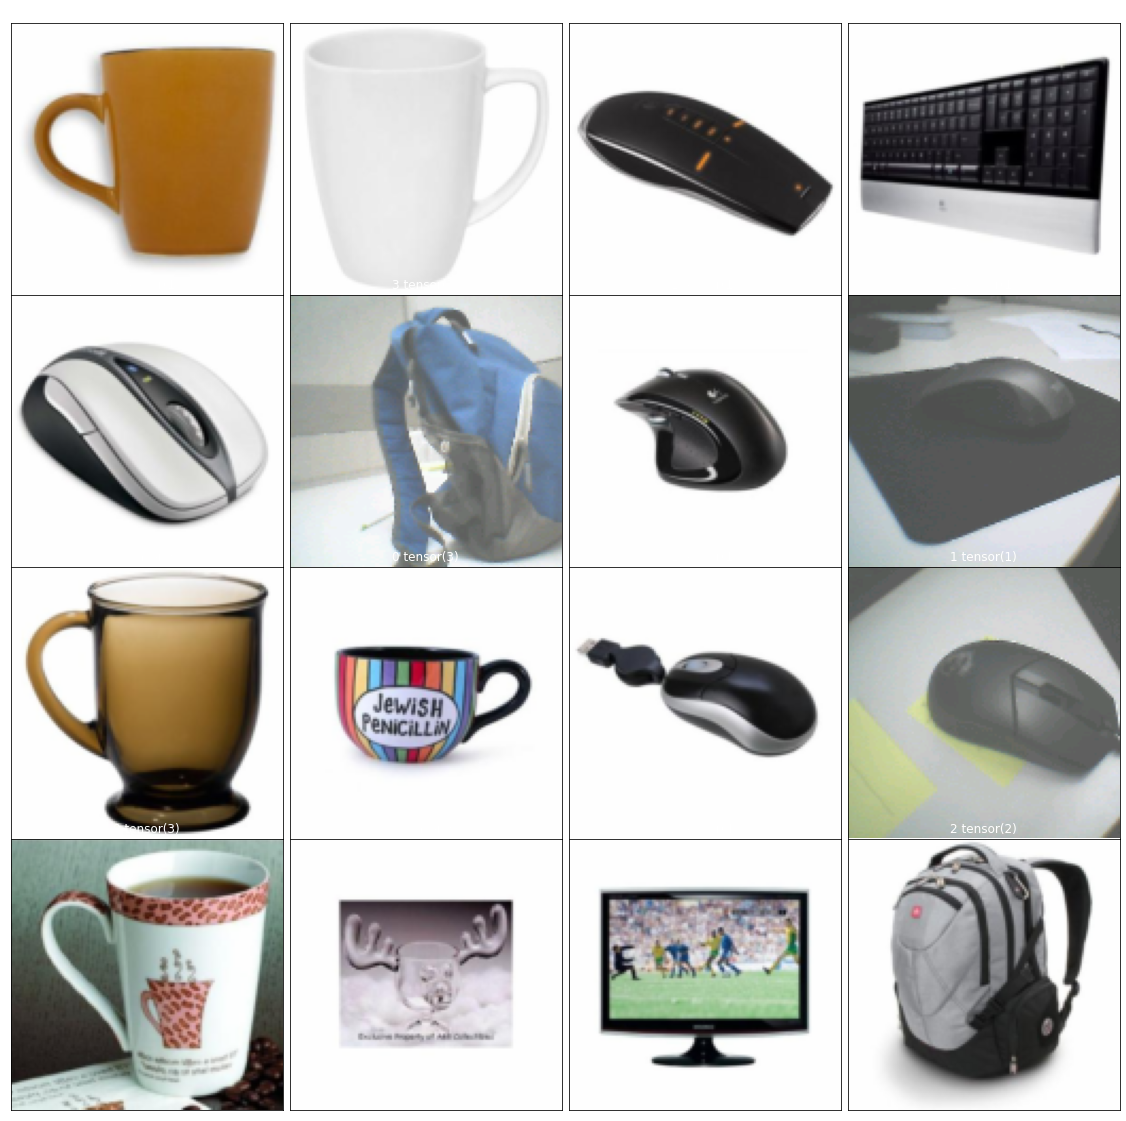

In [14]:
train_set, test_set = conf.dataset_fn(((conf.source_data_path,conf.target_data_path), args), load_train=True, load_test=True)
train_set.visualize_batch()

## Create the dataloaders

In [15]:
train_loader, val_loader, test_loader, _ = apputils.get_data_loaders(conf.dataset_fn, ((conf.source_data_path,conf.target_data_path), args), conf.batch_size, conf.workers, conf.validation_split, conf.deterministic,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader.sampler), len(val_loader.sampler), len(test_loader.sampler))
msglogger.info('Augmentations:%s',train_loader.dataset.transform)

../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18923  G2 =  3496  G3 =  95266  G4 =  13984


Dataset sizes:
	training=12586
	validation=1398
	test=828
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  207  G2 =  384  G3 =  1128  G4 =  1536


## Set up the device

In [16]:
conf.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(conf.device))

Running on device: cuda:0


## Set up the model

In [17]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the model
model = mod.OfficeDCD()
msglogger.info('model: %s',model)
model = model.to(conf.device)

msglogger.info('Number of Model Params: %d',count_params(model))

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf.dimensions)
tflogger.tblogger.writer.add_graph(model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

model: OfficeDCD(
  (fc1): FusedLinearReLU(
    (activate): ReLU(inplace=True)
    (op): Linear(in_features=128, out_features=64, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (fc2): Linear(
    (activate): Empty()
    (op): Linear(in_features=64, out_features=4, bias=True)
    (calc_out_shift): OutputShiftSqueeze()
    (calc_weight_scale): One()
    (scale): Scaler()
    (calc_out_scale): OutputScale()
    (quantize_weight): Empty()
    (quantize_bias): Empty()
    (clamp_weight): Empty()
    (clamp_bias): Empty()
    (quantize): Empty()
    (clamp): Clamp()
    (quantize_pool): Empty()
    (clamp_pool): Empty()
  )
  (do): Dropout(p=0.2, inplace=False)
)


Configuring device: MAX78000, simulate=False.


Number of Model Params: 8516


In [18]:
# optimizer
conf.optimizer = optim.Adam(model.parameters(), lr=conf.lr)
msglogger.info('Optimizer Type: %s', type(conf.optimizer))

# lr schedule
conf.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf.optimizer, milestones=[10, 35,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf.lr_scheduler.base_lrs)+" milestones: "+str(conf.lr_scheduler.milestones)+ " gamma: "+str(conf.lr_scheduler.gamma))

# loss function
conf.criterion = torch.nn.CrossEntropyLoss().to(conf.device)
compression_scheduler = distiller.CompressionScheduler(model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.0015] milestones: Counter({10: 1, 35: 1, 100: 1}) gamma: 0.5


## Define the forward function

In [19]:
# load the encoder-classifier model
load_model_path = "jupyter_logging/finetune_office5_run2___2022.07.14-092138/classifierbackbonenet_qat_best.pth.tar"
enc_model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf.device)

# register a forward hook to get the encoder output
conf.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
conf.enc_model = enc_model

def cd_DCD_forward(model, batch, conf):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

conf.forward = cd_DCD_forward

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

In [161]:
# %load_ext autoreload
# %autoreload 2

In [20]:
train(train_loader, val_loader, test_loader, model,conf)

Training epoch: 12586 samples (32 per mini-batch)
Epoch: [0][  100/  394]    objective_loss 1.070859                                        LR 0.001500    
Epoch: [0][  200/  394]    objective_loss 0.947673                                        LR 0.001500    
Epoch: [0][  300/  394]    objective_loss 0.869603                                        LR 0.001500    
Epoch: [0][  394/  394]    objective_loss 0.818688    Top1 85.714286    LR 0.001500    
--- validate (epoch=0)-----------
1398 samples (32 per mini-batch)
Epoch: [0][   44/   44]    Loss 0.622068    Top1 78.254649    
==> Top1: 78.255    Loss: 0.622

==> Confusion:
[[309  17  18   5]
 [ 55 241   2  21]
 [  8  18 275  68]
 [ 17  24  51 269]]

==> Best [Top1: 78.255 on epoch: 0]
Saving checkpoint to: jupyter_logging/office_dcd_train_k8___2022.07.14-144048/officedcdnet_checkpoint.pth.tar
Training epoch: 12586 samples (32 per mini-batch)
Epoch: [1][  100/  394]    objective_loss 0.592695                                        LR

QAT is starting!


Epoch: [4][  100/  394]    objective_loss 0.770995                                        LR 0.001500    
Epoch: [4][  200/  394]    objective_loss 0.730501                                        LR 0.001500    
Epoch: [4][  300/  394]    objective_loss 0.698940                                        LR 0.001500    
Epoch: [4][  394/  394]    objective_loss 0.677599    Top1 95.238095    LR 0.001500    
--- validate (epoch=4)-----------
1398 samples (32 per mini-batch)
Epoch: [4][   44/   44]    Loss 0.587849    Top1 83.977110    
==> Top1: 83.977    Loss: 0.588

==> Confusion:
[[287  28  26   8]
 [ 19 288   1  11]
 [  8  11 325  25]
 [ 11  29  47 274]]

==> Best [Top1: 83.977 on epoch: 4]
Saving checkpoint to: jupyter_logging/office_dcd_train_k8___2022.07.14-144048/officedcdnet_qat_checkpoint.pth.tar
Training epoch: 12586 samples (32 per mini-batch)
Epoch: [5][  100/  394]    objective_loss 0.583032                                        LR 0.001500    
Epoch: [5][  200/  394]    objec

## Now do adversarial training to trick the discriminator

In [2]:
import importlib

import os
from matplotlib.image import imread
import numpy as np
import matplotlib.pyplot as plt
import time
import logging
from collections import OrderedDict
from datetime import datetime

try:
    import tensorboard  # pylint: disable=import-error
    import tensorflow  # pylint: disable=import-error
    tensorflow.io.gfile = tensorboard.compat.tensorflow_stub.io.gfile
except (ModuleNotFoundError, AttributeError):
    pass

import torch
from torch import nn
import torchnet.meter as tnt
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import nnplot
import operator
import distiller
import distiller.apputils as apputils
from distiller.data_loggers import PythonLogger, TensorBoardLogger
import torch.nn.functional as F

import sys
# modules from subdirectories
sys.path.insert(0, 'models/')
sys.path.insert(1, 'distiller/')
sys.path.insert(2, 'datasets/')

# import models and datasets
from classification import *
mod = importlib.import_module("minivgg")

import ai8x
%matplotlib inline

# Logger handle
msglogger = None

# helper functions
class Args:
    def __init__(self, act_mode_8bit):
        self.act_mode_8bit = act_mode_8bit
        self.truncate_testset = False

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

args = Args(act_mode_8bit=False)

In [3]:
class Config:
    def __init__(self):
        self.dataset_name = "pairs"
        self.dataset_fn = pairs_get_datasets
        self.num_classes = 4
        self.model_name = "officedcdnet"
        self.dimensions = (1,128)
        self.workers = 4
        self.batch_size = 32
        self.validation_split = 0.1
        self.log_prefix = "dcd_train_adv_k8run3_tsne"
        self.log_dir = "jupyter_logging"
        self.source_data_path = "../Datasets/office5/source/"
        self.target_data_path = "../Datasets/office5/target/"
        self.deterministic = True
        self.print_freq = 32
        self.labels = ('G1', 'G2', 'G3', 'G4')
        self.lr = 0.001
        self.num_epochs = 8
        self.qat_policy = {'start_epoch':2, 'weight_bits':8}
        self.device = None
        self.optimizer = None
        self.criterion = None
        self.adv_criterion = None
        self.lr_scheduler = None
        self.args = args
        self.forward = None
        self.enc_model = None
        self.enc_output = None
        self.dcd_model = None

conf_c = Config()
conf_c.lr = 0.001
conf_c.num_classes = 5
conf_c.labels = ('back_pack', 'keyboard','laptop_computer','mouse','pen')
conf_c.model_name = "officeclassifier"
conf_c.dimensions = (3,128,128)
conf_c.batch_size = 16
conf_c.dataset_fn = pairs_get_datasets_c
conf_d = Config()
conf_cd = Config()

In [4]:
msglogger = apputils.config_pylogger('logging.conf', conf_c.log_prefix, conf_c.log_dir)

# Log various details about the execution environment.
apputils.log_execution_env_state(None, msglogger.logdir)

pylogger = PythonLogger(msglogger, log_1d=True)
all_loggers = [pylogger]

# setup tensorboard
tflogger = TensorBoardLogger(msglogger.logdir, log_1d=True, comment='_'+conf_c.dataset_name)
tflogger.tblogger.writer.add_text('Command line', "args ---")

# log the training configurations
msglogger.info('dataset_name:%s\ndataset_fn=%s\nnum_classes=%d\nmodel_name=%s\ndimensions=%s\nbatch_size=%d\nvalidation_split=%s\nlr=%f\nnum_epochs=%d\nqat_policy=%s',
                conf_c.dataset_name,conf_c.dataset_fn,conf_c.num_classes,conf_c.model_name,conf_c.dimensions,conf_c.batch_size,conf_c.validation_split,conf_c.lr,conf_c.num_epochs,conf_c.qat_policy)

Log file for this run: /home/geffencooper/Model_Development/ai8x-training/jupyter_logging/dcd_train_adv_k8run3_tsne___2022.07.14-154653/dcd_train_adv_k8run3_tsne___2022.07.14-154653.log
dataset_name:pairs
dataset_fn=<function pairs_get_datasets_c at 0x7fdaf48551f0>
num_classes=5
model_name=officeclassifier
dimensions=(3, 128, 128)
batch_size=16
validation_split=0.1
lr=0.001000
num_epochs=8
qat_policy={'start_epoch': 2, 'weight_bits': 8}



--------------------------------------------------------
Logging to TensorBoard - remember to execute the server:
> tensorboard --logdir='./logs'



In [7]:
train_loader_c, val_loader_c, test_loader_c, _ = apputils.get_data_loaders(conf_c.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_c.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
train_loader_d, val_loader_d, test_loader_d, _ = apputils.get_data_loaders(conf_d.dataset_fn, ((conf_c.source_data_path,conf_c.target_data_path), args), conf_d.batch_size, conf_c.workers, conf_c.validation_split, conf_c.deterministic,1, 1, 1)
# _, _, test_loader, _ = apputils.get_data_loaders(cats_and_dogs_get_datasets, ("../Datasets/cats_and_dogs/",args), 32, 1, 0.1, True,1, 1, 1)

# log dataset information
msglogger.info('Dataset sizes:\n\ttraining=%d\n\tvalidation=%d\n\ttest=%d', len(train_loader_c.sampler), len(val_loader_c.sampler), len(test_loader_c.sampler))
msglogger.info('Augmentations:%s',train_loader_c.dataset.transform)

../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18923  G2 =  3496  G3 =  95266  G4 =  13984
../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  207  G2 =  384  G3 =  1128  G4 =  1536
../Datasets/office5/source/train
../Datasets/office5/target/train
../Datasets/office5/source/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/train
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  18923  G2 =  3496  G3 =  95266  G4 =  1

Dataset sizes:
	training=6293
	validation=699
	test=414
Augmentations:Compose(
    Resize(size=(128, 128), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)


../Datasets/office5/source/test
../Datasets/office5/target/test
../Datasets/office5/source/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
../Datasets/office5/target/test
{'keyboard': 0, 'mouse': 1, 'back_pack': 2, 'mug': 3, 'monitor': 4}
Max possible pairs: G1 =  207  G2 =  384  G3 =  1128  G4 =  1536


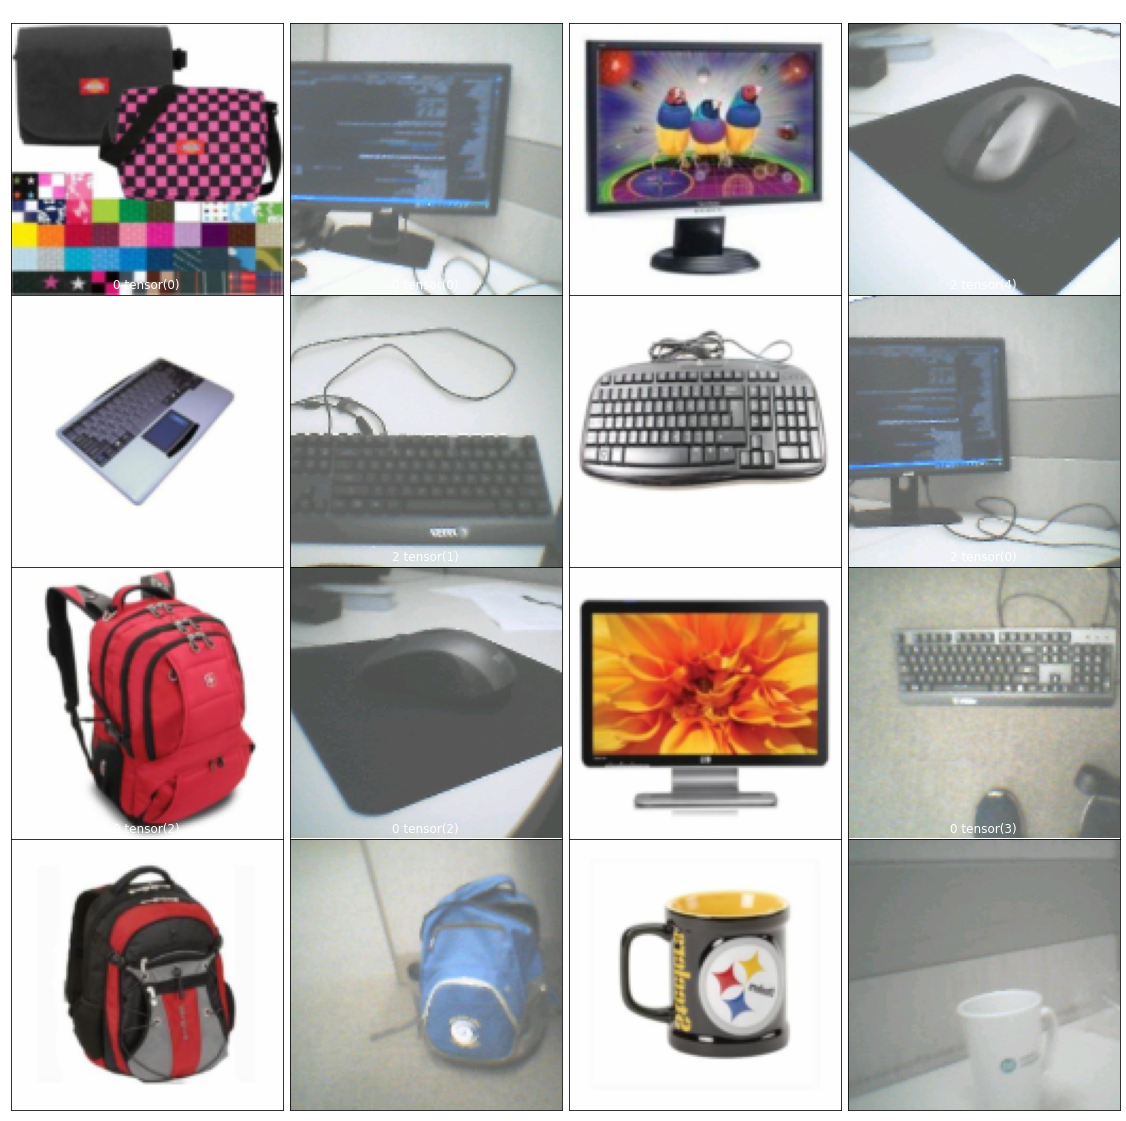

In [61]:
train_loader_c.dataset.visualize_batch()

In [6]:
conf_c.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
conf_d.device = conf_c.device
print('Running on device: {}'.format(conf_c.device))

Running on device: cuda:0


In [8]:
# set simulation configuration
ai8x.set_device(device=85, simulate=False, round_avg=False)

# create the classifier model
load_model_path = "jupyter_logging/finetune_office5_run2___2022.07.14-092138/classifierbackbonenet_qat_best.pth.tar"
enc_model = mod.OfficeClassifier()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(enc_model)
enc_model = apputils.load_lean_checkpoint(enc_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(enc_model)
enc_model = enc_model.to(conf_c.device)

# create the DCD model
load_model_path = "jupyter_logging/office_dcd_train_k8___2022.07.14-144048/officedcdnet_qat_best.pth.tar"
dcd_model = mod.OfficeDCD()                       
checkpoint = torch.load(load_model_path, map_location=lambda storage, loc: storage)
ai8x.fuse_bn_layers(dcd_model)
dcd_model = apputils.load_lean_checkpoint(dcd_model, load_model_path, model_device=conf_c.device)
ai8x.update_model(dcd_model)
dcd_model = dcd_model.to(conf_c.device)

# configure tensorboard
dummy_input1 = torch.randn((1, ) + conf_c.dimensions)
tflogger.tblogger.writer.add_graph(enc_model.to('cpu'), (dummy_input1,), False)

all_loggers.append(tflogger)
all_tbloggers = [tflogger]

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

Configuring device: MAX78000, simulate=False.


=> loaded 'state_dict' from checkpoint 'jupyter_logging/finetune_office5_run2___2022.07.14-092138/classifierbackbonenet_qat_best.pth.tar'
=> loading checkpoint jupyter_logging/office_dcd_train_k8___2022.07.14-144048/officedcdnet_qat_best.pth.tar
=> Checkpoint contents:
+----------------------+-------------+------------------+
| Key                  | Type        | Value            |
|----------------------+-------------+------------------|
| arch                 | str         | officedcdnet_qat |
| compression_sched    | dict        |                  |
| epoch                | int         | 22               |
| extras               | dict        |                  |
| optimizer_state_dict | dict        |                  |
| optimizer_type       | type        | Adam             |
| state_dict           | OrderedDict |                  |
+----------------------+-------------+------------------+

=> Checkpoint['extras'] contents:
+--------------+--------+---------+
| Key          | Type

In [64]:
# optimizer
conf_c.optimizer = optim.Adam(enc_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_c.optimizer))

conf_d.optimizer = optim.Adam(dcd_model.parameters(), lr=conf_c.lr)
msglogger.info('Optimizer Type: %s', type(conf_d.optimizer))

# lr schedule
conf_c.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_c.optimizer, milestones=[2, 20,100], gamma=0.5)
conf_d.lr_scheduler = optim.lr_scheduler.MultiStepLR(conf_d.optimizer, milestones=[2, 20,100], gamma=0.5)
msglogger.info("lr_schedule:%s","base: "+str(conf_c.lr_scheduler.base_lrs)+" milestones: "+str(conf_c.lr_scheduler.milestones)+ " gamma: "+str(conf_c.lr_scheduler.gamma))

def dcd_adv_loss(output, target):
    g2s = F.log_softmax(output[target == 0])
    g4s = F.log_softmax(output[target == 2])

    # print("output: ", output)
    # print("target: ", target)

    # print("G2 log-softmax: ", g2s)
    # print("G4 log-softmax: ", g2s)

    term_1 = F.nll_loss(g2s,target[target == 0])
    term_2 = -F.nll_loss(g4s,target[target == 2])

    # print("term 1: ", term_1)
    # print("term 2: ", term_2)
    # () + 1
    
    return term_1 + term_2 

# loss function
#conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_c.device)
conf_c.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
conf_c.adv_criterion = dcd_adv_loss
conf_d.criterion = torch.nn.CrossEntropyLoss().to(conf_d.device)
compression_scheduler_c = distiller.CompressionScheduler(enc_model)
compression_scheduler_d = distiller.CompressionScheduler(dcd_model)

Optimizer Type: <class 'torch.optim.adam.Adam'>
Optimizer Type: <class 'torch.optim.adam.Adam'>
lr_schedule:base: [0.001] milestones: Counter({2: 1, 20: 1, 100: 1}) gamma: 0.5


In [65]:
# register a forward hook to get the encoder output
conf_c.enc_output = {}
def get_embedding(name):
    def hook(model, input, output):
        conf_c.enc_output[name] = output.detach()
    return hook

# get the activations
enc_model.feature_extractor.fc2.register_forward_hook(get_embedding('fc2'))
enc_model = enc_model.to(conf_c.device)
conf_c.enc_model = enc_model

conf_d.dcd_model = dcd_model

def cd_DCD_forward(model, batch, conf, conf_c):
    inputs1, inputs2, target, img1_label, imgs2_label = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf_c.enc_model(inputs1)
    enc1 = conf_c.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf_c.enc_model(inputs2)
    enc2 = conf_c.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)
    return model(X_cat.detach()), target

def cd_classifier_forward(model, batch, conf, conf_d):
    inputs1, inputs2, target, imgs1_labels, imgs2_labels = batch[0].to(conf.device), batch[1].to(conf.device), batch[2].to(conf.device), batch[3].to(conf.device), batch[4].to(conf.device)

    # encoder output for sample 1
    out1 = conf.enc_model(inputs1)
    enc1 = conf.enc_output['fc2']

    # encoder output for sample 2
    out2 = conf.enc_model(inputs2)
    enc2 = conf.enc_output['fc2']

    # concatenate and pass through DCD
    X_cat = torch.cat([enc1,enc2],1)

    # the dcd output and target as well as the classifier outputs and targets
    return conf_d.dcd_model(X_cat.detach()), target, model(inputs1), imgs1_labels, model(inputs2), imgs2_labels

def cd_classifier_forward2(model, batch, conf):
    # get the batch items and send to GPU
    inputs, target = batch[0].to(conf.device), batch[1].to(conf.device)

    # get the output
    return model(inputs), target

conf_d.forward = cd_DCD_forward
conf_c.forward = cd_classifier_forward
conf_cd.forward = cd_classifier_forward2
conf_cd.device = conf_d.device
conf_cd.criterion = conf_c.criterion
conf_cd.num_classes = conf_c.num_classes


In [66]:
batch = next(iter(test_loader_d))
out, target = conf_d.forward(dcd_model,batch,conf_d,conf_c)
print(torch.argmax(out,axis=1)-target)

tensor([ 0, -1,  0,  0,  0,  0, -1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, -1, -2,  2],
       device='cuda:0')


In [67]:
def adv_validate(val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, loggers, epoch=-1, tflogger=-1):
    
    # store loss stats
    enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
    disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

    classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
    classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
    classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

    # validation set info
    total_samples = len(val_loader_c.sampler)
    batch_size = val_loader_c.batch_size

    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)
    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

    total_steps = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
    msglogger.info('%d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

    # Switch to evaluation mode
    classifier_model.eval()
    discriminator_model.eval()

    class_probs = []
    class_preds = []
    dcd_c_probs = []
    dcd_c_preds = []
    dcd_d_probs = []
    dcd_d_preds = []

    # iterate over the batches in the validation set
    for validation_step in range(32):
        with torch.no_grad():
            
            batch_c = next(iter(val_loader_c)) # get a single batch
            batch_d = next(iter(val_loader_d))

            # pass the input through the classifier
            dcd_out_c, dcd_target_c, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch_c, conf_c, conf_d)
            # print("output: ", dcd_out_c)
            # print("target: ", dcd_target_c)

            # pass the input through the dcd
            dcd_out_d, dcd_target_d = conf_d.forward(discriminator_model, batch_d, conf_d, conf_c)
            
            # print(conf_c.device)
            # print(conf_d.device)
            # print("model on gpu:", next(classifier_model.parameters()).is_cuda)
            # print("model on gpu:", next(discriminator_model.parameters()).is_cuda)

            # correct output for accurate loss calculation
            if conf_c.args.act_mode_8bit:
                dcd_out_c /= 128.
                dcd_out_d /= 128.
                img1_out /= 128.
                img2_out /= 128.
                for key in model.__dict__['_modules'].keys():
                    if (hasattr(model.__dict__['_modules'][key], 'wide')
                            and model.__dict__['_modules'][key].wide):
                        dcd_out_c /= 256.
                        dcd_out_d /= 256.
                        img1_out /= 256.
                        img2_out /= 256.
            
            # collect all the losses
            dcd_loss = conf_c.adv_criterion(dcd_out_c, dcd_target_c)
            img1_loss = conf_c.criterion(img1_out, img1_target)
            img2_loss = conf_c.criterion(img2_out, img2_target)
            loss = dcd_loss + img1_loss + img2_loss
            enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
            enc_losses['disc_c_loss'].add(dcd_loss.item())

            # collect accuracy stats
            classerr_class.add(img1_out.data, img1_target)
            classerr_class.add(img2_out.data, img2_target)
            classerr_disc_c.add(dcd_out_c.data, dcd_target_c)

            confusion_class.add(img1_out.data, img1_target)
            confusion_class.add(img2_out.data, img2_target)
            confusion_disc_c.add(dcd_out_c.data, dcd_target_c)


            dcd_loss_d = conf_d.criterion(dcd_out_d, dcd_target_d)
            disc_losses['disc_d_loss'].add(dcd_loss_d.item())

            classerr_disc_d.add(dcd_out_d.data, dcd_target_d)
            confusion_disc_d.add(dcd_out_d.data, dcd_target_d)
            

            # store prediction stats
            steps_completed = (validation_step+1)
            if steps_completed % conf_c.print_freq == 0 or steps_completed == total_steps:
                class_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in torch.cat((img1_out,img2_out))]
                dcd_c_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_c]
                dcd_d_probs_batch = [torch.nn.functional.softmax(el, dim=0) for el in dcd_out_d]

                _, class_preds_batch = torch.max(torch.cat((img1_out,img2_out)), 1)
                _, dcd_c_preds_batch = torch.max(dcd_out_c, 1)
                _, dcd_d_preds_batch = torch.max(dcd_out_d, 1)

                class_probs.append(class_probs_batch)
                class_preds.append(class_preds_batch)
                dcd_c_probs.append(dcd_c_probs_batch)
                dcd_c_preds.append(dcd_c_preds_batch)
                dcd_d_probs.append(dcd_d_probs_batch)
                dcd_d_preds.append(dcd_d_preds_batch)

                stats = (
                    '',
                    OrderedDict([('Class Loss', enc_losses['class_loss'].mean),
                                 ('disc_c Loss', enc_losses['disc_c_loss'].mean),
                                 ('disc_d Loss', disc_losses['disc_d_loss'].mean),
                                    ('Class Top1', classerr_class.value(1)),
                                    ('disc_c Top1', classerr_disc_c.value(1)),
                                    ('disc_d Top1', classerr_disc_d.value(1))]),
                                    
                )
                if conf_c.num_classes > 5:
                    stats[1]['Top5'] = classerr_class.value(5)

                distiller.log_training_progress(stats, None, epoch, steps_completed,
                                                total_steps, conf_c.print_freq, loggers)


    if conf_c.num_classes > 5:
        msglogger.info('==> Class Top1: %.3f    Class Top5: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0], classerr_class.value()[1],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)
    else:
        msglogger.info('==> Class Top1: %.3f    Class Loss: %.3f    DCD_c Top1: %.3f DCD_c Loss: %.3f    DCD_d Top1: %.3f DCD_d Loss: %.3f\n',
                        classerr_class.value()[0],
                        enc_losses['class_loss'].mean, classerr_disc_c.value()[0], enc_losses['disc_c_loss'].mean,
                        classerr_disc_d.value()[0], disc_losses['disc_d_loss'].mean)

    msglogger.info('==> Confusion Class:\n%s\n', str(confusion_class.value()))
    msglogger.info('==> Confusion DCD_c:\n%s\n', str(confusion_disc_c.value()))
    msglogger.info('==> Confusion DCD_d:\n%s\n', str(confusion_disc_d.value()))

    if tflogger is not None:
        cf = nnplot.confusion_matrix(confusion_class.value(), conf_c.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_class', cf, epoch,
                                            dataformats='HWC')
        cf = nnplot.confusion_matrix(confusion_disc_c.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_c', cf, epoch,
                                            dataformats='HWC')

        cf = nnplot.confusion_matrix(confusion_disc_d.value(), conf_d.labels)
        tflogger.tblogger.writer.add_image('Validation/ConfusionMatrix_disc_d', cf, epoch,
                                            dataformats='HWC')
    
    return classerr_class.value(1), classerr_class.value(min(conf_c.num_classes, 5)), enc_losses['class_loss'].mean, classerr_disc_c.value(1), enc_losses['disc_c_loss'].mean, classerr_disc_d.value(1), disc_losses['disc_d_loss'].mean

In [68]:
def adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, classifier_model, conf_c, discriminator_model, conf_d, conf_cd):

    # store model history across epochs
    perf_scores_history = []

    classifier_model = classifier_model.to(conf_c.device)
    discriminator_model = discriminator_model.to(conf_d.device)

    # start the clock
    tic = datetime.now()

    batches_per_phase = 4

    # =============================== training loop =====================================
    for epoch in range(0, conf_c.num_epochs):
        # check if need to switch to QAT
        if epoch > 0 and epoch == conf_c.qat_policy['start_epoch']:
            print('QAT is starting!')
            # Fuse the BN parameters into conv layers before Quantization Aware Training (QAT)
            ai8x.fuse_bn_layers(classifier_model)
            ai8x.fuse_bn_layers(discriminator_model)

            # Switch model from unquantized to quantized for QAT
            ai8x.initiate_qat(classifier_model, conf_c.qat_policy)
            ai8x.initiate_qat(discriminator_model, conf_d.qat_policy)

            # Model is re-transferred to GPU in case parameters were added
            classifier_model.to(conf_c.device)
            discriminator_model.to(conf_d.device)

            # Empty the performance scores list for QAT operation
            perf_scores_history = []
            conf_c.model_name = f'{conf_c.model_name}_qat'
            conf_d.model_name = f'{conf_d.model_name}_qat'

        # store loss and training stats
        enc_losses = {'class_loss': tnt.AverageValueMeter(),'disc_c_loss': tnt.AverageValueMeter()}
        disc_losses = {'disc_d_loss': tnt.AverageValueMeter()}

        classerr_class = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_c.num_classes, 5))) # classification error
        classerr_disc_c = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error classification phase
        classerr_disc_d = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(conf_d.num_classes, 5))) # discriminator error during dcd phase

        # logging stats
        total_samples = len(train_loader_c.sampler)
        steps_per_epoch = (total_samples + conf_c.batch_size - 1) // conf_c.batch_size
        msglogger.info('Training epoch: %d samples (%d per mini-batch)', total_samples, conf_c.batch_size)

        # Switch to train mode
        classifier_model.train()
        discriminator_model.train()
        acc_stats = []

        # =================================== batch loop ===================================
        encoder_on = False
        switch_d = False
        switch_c = False

        print("steps in an epoch:", len(train_loader_c))

        #for train_step, batch in enumerate(train_loader_c):
        for train_step in range(64): # reduce epocj to 64 batches since we are randomly sampling
            # switch phase every four batches
            if (train_step % batches_per_phase) == 0:
                if encoder_on == True: # switch to train dcd
                    switch_d = True
                if encoder_on == False: # switch to train encoder
                    switch_c = True
                encoder_on = not encoder_on

            # train the encoder to trick the discriminator
            if encoder_on:
                if switch_c == True: # create new error collectors at the start of the phase
                    switch_c = False
                    confusion_class = tnt.ConfusionMeter(conf_c.num_classes)
                    confusion_disc_c = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_c)) # get a single batch

                # pass the input through the classifier
                dcd_out, dcd_target, img1_out, img1_target, img2_out, img2_target = conf_c.forward(classifier_model, batch, conf_c, conf_d) 
                
                # collect all the losses
                dcd_loss = conf_c.adv_criterion(dcd_out, dcd_target)
                img1_loss = conf_c.criterion(img1_out, img1_target)
                img2_loss = conf_c.criterion(img2_out, img2_target)
                loss = dcd_loss + img1_loss + img2_loss

                # collect accuracy stats
                classerr_class.add(img1_out.data, img1_target)
                classerr_class.add(img2_out.data, img2_target)
                classerr_disc_c.add(dcd_out.data, dcd_target)

                confusion_class.add(img1_out.data, img1_target)
                confusion_class.add(img2_out.data, img2_target)
                confusion_disc_c.add(dcd_out.data, dcd_target)
                
                # add the losses
                enc_losses['class_loss'].add(img1_loss.item() + img2_loss.item())
                enc_losses['disc_c_loss'].add(dcd_loss.item())

                # reset the optimizer
                conf_c.optimizer.zero_grad()

                # backwards pass and parameter update
                loss.backward()
                conf_c.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats
                if (steps_completed+batches_per_phase) % conf_c.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_class.n != 0:
                        errs['class Top1'] = classerr_class.value(1)
                        errs['disc_c Top1'] = classerr_disc_c.value(1)
                        if conf_c.num_classes > 5:
                            errs['class Top5'] = classerr_class.value(5)
                    else:
                        errs['class Top1'] = None
                        errs['class Top5'] = None
                        errs['disc_c Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in enc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_c.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_c/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_c.print_freq,all_loggers)

            # train the discriminator
            else:
                if switch_d == True:
                    switch_d = False
                    confusion_disc_d = tnt.ConfusionMeter(conf_d.num_classes)

                batch = next(iter(train_loader_d))

                # pass the input through the dcd
                dcd_out, dcd_target = conf_d.forward(discriminator_model, batch, conf_d, conf_c) 
                
                dcd_loss_d = conf_d.criterion(dcd_out, dcd_target)

                classerr_disc_d.add(dcd_out.data, dcd_target)
                confusion_disc_d.add(dcd_out.data, dcd_target)
                
                disc_losses['disc_d_loss'].add(dcd_loss_d.item())

                # reset the optimizer
                conf_d.optimizer.zero_grad()

                # backwards pass and parameter update
                dcd_loss_d.backward()
                conf_d.optimizer.step()

                # track batch stats
                steps_completed = (train_step+1)

                # log stats every 10 batches
                if steps_completed % conf_d.print_freq == 0 or steps_completed == steps_per_epoch:
                    # Log some statistics
                    errs = OrderedDict()
                    if classerr_disc_d.n != 0:
                        errs['disc_d Top1'] = classerr_disc_d.value(1)
                    else:
                        errs['disc_d Top1'] = None

                    stats_dict = OrderedDict()
                    for loss_name, meter in disc_losses.items():
                        stats_dict[loss_name] = meter.mean
                    stats_dict.update(errs)
                    
                    stats_dict['LR'] = conf_d.optimizer.param_groups[0]['lr']
                    stats = ('Adv/Training_d/', stats_dict)
                    params = None
                    distiller.log_training_progress(stats,params,epoch,steps_completed,steps_per_epoch,conf_d.print_freq,all_loggers)


        # ============================= validation =======================
        msglogger.info('--- validate (epoch=%d)-----------', epoch)
        class_top1, class_top5, class_loss, disc_c_top1, disc_c_loss, disc_d_top1, disc_d_loss = adv_validate(val_loader_c, val_loader_d, classifier_model,\
                                                                                                          conf_c, discriminator_model, conf_d, [pylogger], epoch, tflogger)

        # store validation stats
        stats = (
                    'Adv/Validation/',
                    OrderedDict([('Class Loss', class_loss),
                                 ('disc_c Loss', disc_c_loss),
                                 ('disc_d Loss', disc_d_loss),
                                    ('Class Top1', class_top1),
                                    ('disc_c Top1', disc_c_top1),
                                    ('disc_d Top1', disc_d_top1)]),
                                    
                )
        
        if conf_c.num_classes > 5:
            stats[1]['Top5'] = classerr_class.value(5)

        distiller.log_training_progress(stats, None, epoch, steps_completed=0, total_steps=1,
                                                log_freq=1, loggers=all_tbloggers)

        perf_scores_history.append(distiller.MutableNamedTuple({'disc_d_loss': disc_d_loss, 'epoch': epoch}))
        # Keep perf_scores_history sorted from best to worst
        # Sort by top1 as main sort key, then sort by top5 and epoch
        perf_scores_history.sort(key=operator.attrgetter('disc_d_loss','epoch'),reverse=True)
        for score in perf_scores_history[:1]:
            msglogger.info('==> Best [disc_d_loss: %.3f on epoch: %d]',
                            score.disc_d_loss, score.epoch)

        # Save the checkpoint
        is_best = epoch == perf_scores_history[0].epoch
        checkpoint_extras = {'current_disc_d_loss': disc_d_loss,
                            'best_disc_d_loss': perf_scores_history[0].disc_d_loss,
                            'best_epoch': perf_scores_history[0].epoch}

        apputils.save_checkpoint(epoch, conf_c.model_name, classifier_model, optimizer=conf_c.optimizer,
                                    scheduler=compression_scheduler_c, extras=checkpoint_extras,
                                    is_best=is_best, name=conf_c.model_name,
                                    dir=msglogger.logdir)

        conf_c.lr_scheduler.step()
        conf_d.lr_scheduler.step()

    # ========================= test ============================
    # top1, top5, losses = validate(val_loader, model, [pylogger], conf, epoch, tflogger)
    # msglogger.info('==> Test Set [Top1: %.3f   Top5: %.3f  on test set]', top1, top5)
    msglogger.info('Training time: %s', datetime.now() - tic)

In [69]:
adv_train(train_loader_c, train_loader_d, val_loader_c, val_loader_d, enc_model, conf_c, dcd_model, conf_d, conf_cd)

Training epoch: 6293 samples (16 per mini-batch)


steps in an epoch: 394


Epoch: [0][   28/  394]    class_loss 0.875269    disc_c_loss 0.262301    class Top1 87.500000    disc_c Top1 67.578125    LR 0.001000    
Epoch: [0][   32/  394]    disc_d_loss 1.402494    disc_d Top1 39.062500    LR 0.001000    
Epoch: [0][   60/  394]    class_loss 0.542832    disc_c_loss 0.227731    class Top1 92.871094    disc_c Top1 61.523438    LR 0.001000    
Epoch: [0][   64/  394]    disc_d_loss 1.264528    disc_d Top1 39.746094    LR 0.001000    
--- validate (epoch=0)-----------
699 samples (16 per mini-batch)
Epoch: [0][   32/   44]    Class Loss 0.127528    disc_c Loss 0.145265    disc_d Loss 1.086949    Class Top1 100.000000    disc_c Top1 52.734375    disc_d Top1 48.242188    
==> Class Top1: 100.000    Class Loss: 0.128    DCD_c Top1: 52.734 DCD_c Loss: 0.145    DCD_d Top1: 48.242 DCD_d Loss: 1.087

==> Confusion Class:
[[328   0   0   0   0]
 [  0 192   0   0   0]
 [  0   0 215   0   0]
 [  0   0   0 136   0]
 [  0   0   0   0 153]]

==> Confusion DCD_c:
[[136 116   0

steps in an epoch: 394


Epoch: [1][   28/  394]    class_loss 0.098859    disc_c_loss 0.050054    class Top1 100.000000    disc_c Top1 52.343750    LR 0.001000    
Epoch: [1][   32/  394]    disc_d_loss 1.079020    disc_d Top1 52.734375    LR 0.001000    
Epoch: [1][   60/  394]    class_loss 0.085014    disc_c_loss 0.019812    class Top1 100.000000    disc_c Top1 41.015625    LR 0.001000    
Epoch: [1][   64/  394]    disc_d_loss 1.035035    disc_d Top1 56.933594    LR 0.001000    
--- validate (epoch=1)-----------
699 samples (16 per mini-batch)
Epoch: [1][   32/   44]    Class Loss 0.065642    disc_c Loss -0.072927    disc_d Loss 0.986597    Class Top1 100.000000    disc_c Top1 38.476562    disc_d Top1 59.667969    
==> Class Top1: 100.000    Class Loss: 0.066    DCD_c Top1: 38.477 DCD_c Loss: -0.073    DCD_d Top1: 59.668 DCD_d Loss: 0.987

==> Confusion Class:
[[316   0   0   0   0]
 [  0 170   0   0   0]
 [  0   0 198   0   0]
 [  0   0   0 158   0]
 [  0   0   0   0 182]]

==> Confusion DCD_c:
[[120 145

QAT is starting!
steps in an epoch: 394


Traceback (most recent call last):
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Epoch: [2][   28/  394]    class_loss 0.063269    disc_c_loss -0.074349    class Top1 100.000000    disc_c Top1 38.281250    LR 0.000500    
Epoch: [2][   32/  394]    disc_d_loss 0.976822    disc_d Top1 56.445312    LR 0.000500    
Epoch: [2][   60/  394]    class_loss 0.060506    disc_c_loss -0.088898    class Top1 100.000000 

steps in an epoch: 394


Epoch: [3][   28/  394]    class_loss 0.053310    disc_c_loss -0.074175    class Top1 100.000000    disc_c Top1 57.031250    LR 0.000500    
Epoch: [3][   32/  394]    disc_d_loss 0.952817    disc_d Top1 60.546875    LR 0.000500    
Epoch: [3][   60/  394]    class_loss 0.051617    disc_c_loss -0.075906    class Top1 100.000000    disc_c Top1 55.664062    LR 0.000500    
Epoch: [3][   64/  394]    disc_d_loss 0.929628    disc_d Top1 58.984375    LR 0.000500    
--- validate (epoch=3)-----------
699 samples (16 per mini-batch)
Traceback (most recent call last):
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(t

steps in an epoch: 394


Traceback (most recent call last):
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ie_pv86d'
Epoch: [4][   28/  394]    class_loss 0.046068    disc_c_loss -0.023212    class Top1 100.000000    disc_c Top1 55.859375    LR 0.000500    
Epoch: [4][   32/  394]    disc_d_loss 0.937030    disc_d Top1 52.

steps in an epoch: 394


Epoch: [5][   28/  394]    class_loss 0.040570    disc_c_loss 0.039398    class Top1 100.000000    disc_c Top1 42.187500    LR 0.000500    
Epoch: [5][   32/  394]    disc_d_loss 0.915527    disc_d Top1 57.421875    LR 0.000500    
Epoch: [5][   60/  394]    class_loss 0.039520    disc_c_loss 0.018095    class Top1 100.000000    disc_c Top1 46.093750    LR 0.000500    
Epoch: [5][   64/  394]    disc_d_loss 0.925526    disc_d Top1 56.738281    LR 0.000500    
--- validate (epoch=5)-----------
699 samples (16 per mini-batch)
Epoch: [5][   32/   44]    Class Loss 0.036797    disc_c Loss 0.008429    disc_d Loss 0.935418    Class Top1 100.000000    disc_c Top1 52.343750    disc_d Top1 58.496094    
==> Class Top1: 100.000    Class Loss: 0.037    DCD_c Top1: 52.344 DCD_c Loss: 0.008    DCD_d Top1: 58.496 DCD_d Loss: 0.935

==> Confusion Class:
[[329   0   0   0   0]
 [  0 176   0   0   0]
 [  0   0 223   0   0]
 [  0   0   0 133   0]
 [  0   0   0   0 163]]

==> Confusion DCD_c:
[[171  70  

steps in an epoch: 394


Traceback (most recent call last):
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 722, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/geffencooper/.pyenv/versions/3.8.11/lib/python3.8/shutil.py", line 720, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-zyvyd74b'
Epoch: [6][   28/  394]    class_loss 0.035185    disc_c_loss 0.025121    class Top1 100.000000    disc_c Top1 50.390625    LR 0.000500    
Epoch: [6][   32/  394]    disc_d_loss 0.927709    disc_d Top1 53.5

steps in an epoch: 394


Epoch: [7][   28/  394]    class_loss 0.030523    disc_c_loss 0.047053    class Top1 100.000000    disc_c Top1 51.953125    LR 0.000500    
Epoch: [7][   32/  394]    disc_d_loss 0.916176    disc_d Top1 53.515625    LR 0.000500    
Epoch: [7][   60/  394]    class_loss 0.029922    disc_c_loss 0.075401    class Top1 100.000000    disc_c Top1 47.070312    LR 0.000500    
Epoch: [7][   64/  394]    disc_d_loss 0.910668    disc_d Top1 56.835938    LR 0.000500    
--- validate (epoch=7)-----------
699 samples (16 per mini-batch)
Epoch: [7][   32/   44]    Class Loss 0.027360    disc_c Loss 0.063465    disc_d Loss 0.931951    Class Top1 100.000000    disc_c Top1 40.234375    disc_d Top1 58.886719    
==> Class Top1: 100.000    Class Loss: 0.027    DCD_c Top1: 40.234 DCD_c Loss: 0.063    DCD_d Top1: 58.887 DCD_d Loss: 0.932

==> Confusion Class:
[[357   0   0   0   0]
 [  0 197   0   0   0]
 [  0   0 187   0   0]
 [  0   0   0 126   0]
 [  0   0   0   0 157]]

==> Confusion DCD_c:
[[ 73 193  

## Visualize embeddings again

In [10]:
def adv_viz_embeddings(test_batch_path,conf,batch_size,trained_model_path,model,to_pred=False,dataset_fn=None):
    if dataset_fn != None:
        _, test_set = dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    else:
        _, test_set = conf.dataset_fn((test_batch_path, conf.args), load_train=False, load_test=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    # load the trained model
    ai8x.set_device(device=85, simulate=False, round_avg=False)                      
    checkpoint = torch.load(trained_model_path, map_location=lambda storage, loc: storage)
    ai8x.fuse_bn_layers(model)
    model = apputils.load_lean_checkpoint(model, trained_model_path, model_device=conf.device)
    ai8x.update_model(model)
    model = model.to(conf.device)

    # get a batch of data
    (batch_imgs, batch_labels) = next(iter(test_loader))
    batch_imgs,batch_labels = batch_imgs.to(conf.device), batch_labels.to(conf.device)

    # register forward hook to get embedding output
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # get the activations
    model.eval()
    model.feature_extractor.fc2.register_forward_hook(get_activation('fc2'))
    preds = model(batch_imgs)
    embds = activation['fc2']

    # get the labels
    batch_label_strings = []
    for idx,label in enumerate(batch_labels):
        batch_label_strings.append(test_set.label_dict[label.item()])

    # log to tensorboard
    tflogger.tblogger.writer.add_embedding(
            embds.to('cpu'),
            metadata=batch_label_strings,
            label_img=batch_imgs.to('cpu'),
            global_step=0
        )

    if to_pred:
        print("batch acc: ",np.sum(np.argmax(preds.to('cpu').detach().numpy(),axis=1) == batch_labels.to('cpu').detach().numpy())/len(batch_imgs))

In [11]:
# init the model
model = mod.OfficeClassifier()

# create the embeddings
#adv_viz_embeddings("../Datasets/office5_both/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.08-100329/officeclassifier_qat_best.pth.tar",model,True,office5_get_datasets)
#adv_viz_embeddings("../Datasets/office5_both/",conf_c,128,"jupyter_logging/dcd_train_adv___2022.07.08-143253/officeclassifier_qat_checkpoint.pth.tar",model,True,office5_get_datasets)
adv_viz_embeddings("../Datasets/office5_both/",conf_c,256,"jupyter_logging/dcd_train_adv_k8run3___2022.07.14-151603/officeclassifier_qat_best.pth.tar",model,True,office5_get_datasets)

=> loading checkpoint jupyter_logging/SSL___2022.07.08-153522/classifierbackbonenet_qat_checkpoint.pth.tar
=> Checkpoint contents:
+----------------------+-------------+---------------------------+
| Key                  | Type        | Value                     |
|----------------------+-------------+---------------------------|
| arch                 | str         | classifierbackbonenet_qat |
| compression_sched    | dict        |                           |
| epoch                | int         | 99                        |
| extras               | dict        |                           |
| optimizer_state_dict | dict        |                           |
| optimizer_type       | type        | Adam                      |
| state_dict           | OrderedDict |                           |
+----------------------+-------------+---------------------------+

=> Checkpoint['extras'] contents:
+-------+--------+---------+
| Key   | Type   |   Value |
|-------+--------+---------|
| epoch | 

../Datasets/office5_both/test
{'back_pack_camera': 0, 'mouse_dataset': 1, 'keyboard_dataset': 2, 'monitor_dataset': 3, 'mug_dataset': 4, 'back_pack_dataset': 5, 'keyboard_camera': 6, 'monitor_camera': 7, 'mug_camera': 8, 'mouse_camera': 9}
Configuring device: MAX78000, simulate=False.
batch acc:  0.04090909090909091
